## Importing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
from matplotlib import patches
import csv
import pandas as pd
import os
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

## Annotation txt files to CSV

In [3]:
filelocation = "/content/drive/MyDrive/DDSM/Train/Annotations"
files= [k for k in next(os.walk(f"{filelocation}"))][2]
filenames = []
content=[]
for file in files:
    with open(f"{filelocation}/{file}", 'r', newline='') as source_file:
        filenames.append(file)
        lines = source_file.read()
        content.append(lines)

data = {'Filename':filenames,
        'Content':content}

df = pd.DataFrame(data)
print (df)
df.to_excel('Training.xlsx', index = None, header=True)

                    Filename  \
0     C_0156_1.RIGHT_MLO.txt   
1       C_0088_1.LEFT_CC.txt   
2      D_4059_1.RIGHT_CC.txt   
3     C_0031_1.RIGHT_MLO.txt   
4       C_0023_1.LEFT_CC.txt   
...                      ...   
1755   C_0006_1.LEFT_MLO.txt   
1756  C_0131_1.RIGHT_MLO.txt   
1757  C_0143_1.RIGHT_MLO.txt   
1758   D_4049_1.RIGHT_CC.txt   
1759   D_4103_1.RIGHT_CC.txt   

                                                Content  
0     tumor 320.35203520352036 248.47058823529412 44...  
1     tumor 81.93548387096774 252.23529411764707 322...  
2     tumor 299.17808219178085 172.8 575.34246575342...  
3     tumor 263.8215324927255 277.08235294117645 411...  
4     tumor 130.20452099031215 107.67058823529412 30...  
...                                                 ...  
1755  tumor 434.8325358851675 392.6588235294118 557....  
1756  tumor 316.41912512716175 395.29411764705884 48...  
1757  tumor 337.2279495990836 291.38823529411764 535...  
1758  tumor 510.7070707070707 117.0

In [34]:
import csv
import pandas as pd
import os
filelocation = "/content/drive/MyDrive/DDSM/Test/Annotations "
files= [k for k in next(os.walk(f"{filelocation}"))][2]
filenames = []
content=[]
for file in files:
    with open(f"{filelocation}/{file}", 'r', newline='') as source_file:
        filenames.append(file)
        lines = source_file.read()
        content.append(lines)

data = {'Filename':filenames,
        'Content':content}

df = pd.DataFrame(data)
print (df)
df.to_excel('Validation.xlsx', index = None, header=True)

                   Filename                                            Content
0     A_1622_1.RIGHT_CC.txt  tumor 185.47537227949599 500.70588235294116 21...
1     A_1728_1.LEFT_MLO.txt  tumor 320.63366336633663 332.4235294117647 364...
2     A_1639_1.LEFT_MLO.txt  tumor 556.6332665330661 493.9294117647059 586....
3     B_3372_1.LEFT_MLO.txt  tumor 396.5217391304348 349.36470588235295 431...
4    C_0154_1.RIGHT_MLO.txt  tumor 451.0344827586207 247.34117647058824 600...
..                      ...                                                ...
331  B_3387_1.RIGHT_MLO.txt  tumor 288.5482416591524 321.88235294117646 437...
332   B_3374_1.LEFT_MLO.txt  tumor 1.6724738675958188 321.1294117647059 66....
333    A_1638_1.LEFT_CC.txt  tumor 266.81522748375113 190.11764705882354 51...
334   B_3410_1.LEFT_MLO.txt  tumor 183.10626702997277 304.56470588235294 26...
335   A_1632_1.RIGHT_CC.txt  tumor 445.1080550098232 246.58823529411765 469...

[336 rows x 2 columns]


In [6]:
train = pd.read_csv("/content/trainingfile.xlsx - Sheet1 - trainingfile.xlsx - Sheet1.csv")
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)
train["ClassName"] = "Malignant"

In [7]:
train.columns = train.columns.str.replace('image', 'image_id')

In [8]:
train.head()

,image_id,xmin,ymin,xmax,ymax,ClassName
0,A_1220_1.RIGHT_CC.jpg,262,203,297,225,Malignant
1,A_1140_1.LEFT_MLO.jpg,368,246,512,329,Malignant
2,B_3003_1.RIGHT_CC.jpg,438,255,626,344,Malignant
3,A_1416_1.RIGHT_CC.jpg,62,173,214,259,Malignant
4,A_1626_1.LEFT_MLO.jpg,295,292,334,316,Malignant


In [9]:
train.head()

,image_id,xmin,ymin,xmax,ymax,ClassName
0,A_1220_1.RIGHT_CC.jpg,262,203,297,225,Malignant
1,A_1140_1.LEFT_MLO.jpg,368,246,512,329,Malignant
2,B_3003_1.RIGHT_CC.jpg,438,255,626,344,Malignant
3,A_1416_1.RIGHT_CC.jpg,62,173,214,259,Malignant
4,A_1626_1.LEFT_MLO.jpg,295,292,334,316,Malignant


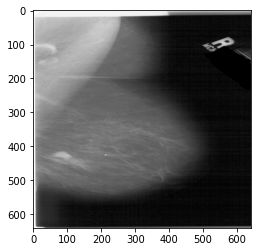

In [35]:
image = plt.imread('/content/drive/MyDrive/DDSM/Train/images/A_1263_1.RIGHT_MLO.jpg')
plt.imshow(image)

In [11]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [12]:
%%time
#Train
wheat_train = train
#Cleaning the Train Data by seperating the bbox into seperate columns for each dimension
wheat_train.head()

CPU times: user 203 µs, sys: 0 ns, total: 203 µs
Wall time: 209 µs


,image_id,xmin,ymin,xmax,ymax,ClassName
0,A_1220_1.RIGHT_CC.jpg,262,203,297,225,Malignant
1,A_1140_1.LEFT_MLO.jpg,368,246,512,329,Malignant
2,B_3003_1.RIGHT_CC.jpg,438,255,626,344,Malignant
3,A_1416_1.RIGHT_CC.jpg,62,173,214,259,Malignant
4,A_1626_1.LEFT_MLO.jpg,295,292,334,316,Malignant


In [13]:
image_ids = wheat_train['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = wheat_train[wheat_train['image_id'].isin(valid_ids)]
train_df = wheat_train[wheat_train['image_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((665, 6), (215, 6))

## Config

In [32]:
class CancerDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)  #reading an image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)    #changing color space BGR --> RGB
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].to_numpy()
        area = (boxes[:, 3]) * (boxes[:, 2])  #Calculating area of boxes
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  #upper coordinate
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  #lower coordinate
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] =  torch.tensor(sample['bboxes']).float()
            return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]
        
def get_train_transform():
    return A.Compose(
        [
            
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transform():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [33]:
def collate_fn(batch):
    return tuple(zip(*batch))

DIR_TRAIN = '/content/drive/MyDrive/DDSM/Train/images'
DIR_TEST = '/content/drive/MyDrive/DDSM/Test/Images'

train_dataset = CancerDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = CancerDataset(valid_df, DIR_TRAIN, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size= 16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[10]['boxes'].cpu().numpy().astype(np.int32)
print(boxes.shape)
sample = images[10].permute(1,2,0).cpu().numpy()

device(type='cuda')

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [22]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [23]:
model = model.to(device)

In [24]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

# Training

In [31]:
total_errors = []
for epoch in range(10):
    losses_arr = []

    for images, targets in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses_arr.append(losses.item())

        losses.backward()
        optimizer.step()

        # update the learning rate
        # lr_scheduler.step()
        
    total_errors.append(np.mean(np.array(losses_arr)))
    if epoch % 1 == 0:
        print("Epoch:{0:3d}, Loss:{1:1.3f}".format(epoch, total_errors[-1]))

Epoch: 0, Loss:1.570
Epoch: 1, Loss:1.539
Epoch: 2, Loss:1.514
Epoch: 3, Loss:1.489
Epoch: 4, Loss:1.462
Epoch: 5, Loss:1.449
Epoch: 6, Loss:1.426
Epoch: 7, Loss:1.415
Epoch: 8, Loss:1.405
Epoch: 9, Loss:1.395


## Evaluation

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

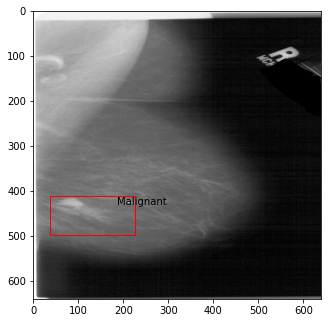

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')